# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 3. Детекция объектов.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### Консультация 2023 года

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [47]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
import glob
import shutil
from pathlib import Path
from xml.etree import ElementTree as ET

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import ultralytics
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib.patches import Rectangle
from PIL import Image
from torch import nn
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm

# !unzip -q data.zip

--2025-05-20 22:10:35--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2025-05-20 22:10:36--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip.5’

data.zip.5          100%[===================>]  36.61M  --.-KB/s    in 0.08s   

2025-05-20 22:10:38 (448 MB/s) - ‘data.zip.5’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [48]:
from zipfile import ZipFile
import os

zip_path = "/content/data.zip"
extract_dir = "/content"

os.makedirs(extract_dir, exist_ok=True)

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [49]:
print(os.listdir('data/xmls'))
print(os.listdir('data/images'))

['IMG_2502.xml', 'IMG_2452.xml', 'IMG_2419.xml', 'cam_image16.xml', 'IMG_2556.xml', 'IMG_2577.xml', 'IMG_2648.xml', 'IMG_2651.xml', 'IMG_2678.xml', 'cam_image1.xml', 'IMG_2465.xml', 'IMG_2531.xml', 'IMG_2608.xml', 'cam_image31.xml', 'cam_image35.xml', 'IMG_2402.xml', 'IMG_2564.xml', 'IMG_2460.xml', 'IMG_2472.xml', 'IMG_2518.xml', 'IMG_2406.xml', 'cam_image5.xml', 'IMG_2559.xml', 'IMG_2574.xml', 'IMG_2656.xml', 'IMG_2400.xml', 'IMG_2427.xml', 'IMG_2653.xml', 'IMG_2642.xml', 'IMG_2476.xml', 'IMG_2474.xml', 'IMG_2512.xml', 'IMG_2495.xml', 'IMG_2462.xml', 'cam_image24.xml', 'cam_image46.xml', 'IMG_2508.xml', 'IMG_2582.xml', 'IMG_2517.xml', 'IMG_2393.xml', 'IMG_2601.xml', 'IMG_2684.xml', 'IMG_2548.xml', 'cam_image33.xml', 'IMG_2664.xml', 'IMG_2407.xml', 'IMG_2624.xml', 'IMG_2424.xml', 'IMG_2497.xml', 'IMG_2668.xml', 'cam_image48.xml', 'IMG_2397.xml', 'IMG_2567.xml', 'IMG_2491.xml', 'IMG_2511.xml', 'IMG_2560.xml', 'IMG_2593.xml', 'IMG_2414.xml', 'IMG_2507.xml', 'IMG_2416.xml', 'IMG_2433.xml'

In [50]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.

        class_name = member.find("name").text
        class_id = class_dict[class_name]

        bndbox = member.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        res = [xmin, ymin, xmax, ymax, class_id]

        bboxes.append(res)

    return bboxes

In [51]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx].replace('\\', '/')
        image = plt.imread(fname)
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        fname = fname.replace('\\', '/')
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [52]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [53]:
train_ds = PascalDataset(root="./data", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data", transform=test_transform, train=False)

In [54]:
train_ds.__get_raw_item__(4)

('./data/images/IMG_2420.JPG', [[69, 172, 229, 398, 2]])

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [55]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        # Вот тут покажите картинку после отката нормализации
        img = train_ds[i]['image'].permute(2, 1, 0).cpu().numpy()
        ax.imshow((img - np.min(img))/(np.max(img) - np.min(img)))

        for bbox in bboxes[i]:
            patch = Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], fc ='none', ec ='lightgreen', lw=2)
            ax.add_patch(patch)
            ax.text(bbox[1], bbox[0] - 7, train_ds.class_dict_inv[bbox[4]], color = 'lightgreen')

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

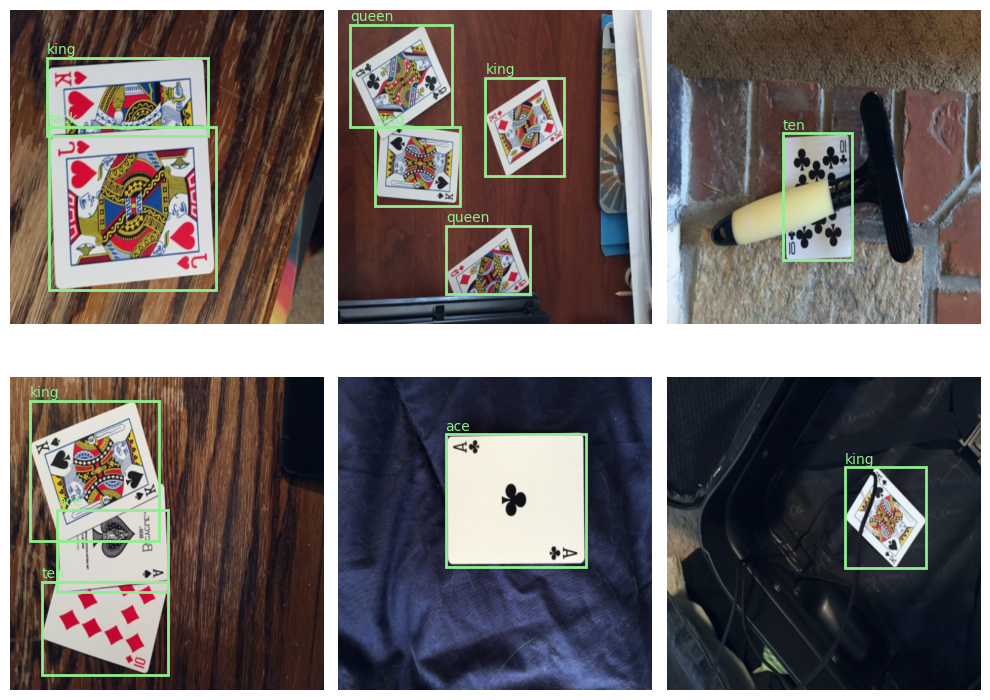

In [56]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код.

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [57]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  32/512
        y_cell =  32/512

        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box =  (xmax - xmin)/512
        h_box =  (ymax - ymin)/512

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2
        cy =  (ymax + ymin) / 2
        cx_idx =  (cx // 32).long()
        cy_idx =  (cy // 32).long()

        cx_box =  (cx % 32)/32
        cy_box =  (cy % 32)/32

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [58]:
def test_collate_fn() -> None:
    target1 = [100, 200, 200, 300, 2]  # xmin, ymin, xmax, ymax, class
    target2_1 = [0, 250, 200, 300, 0]  # xmin, ymin, xmax, ymax, class
    target2_2 = [0, 100, 100, 300, 1]  # xmin, ymin, xmax, ymax, class

    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": [target1]},
            {"image": torch.rand((3, 512, 512)), "bboxes": [target2_1, target2_2]},
        ]
    )

    # Проверяем размерности
    assert result["image"].shape == (2, 3, 512, 512)
    assert result["target"].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(
        result["target"][0, :, 7, 4],
        torch.tensor([22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2]),
    )
    assert np.allclose(
        result["target"][1, :, 8, 3],
        torch.tensor([4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0]),
    )
    assert np.allclose(
        result["target"][1, :, 6, 1],
        torch.tensor([18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1]),
    )

    # Проверяем, что все остальные клеточки содержат нули
    result["target"][0, :, 7, 4] = result["target"][1, :, 8, 3] = result["target"][
        1, :, 6, 1
    ] = torch.zeros(6)
    assert np.allclose(result["target"], 0)


test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

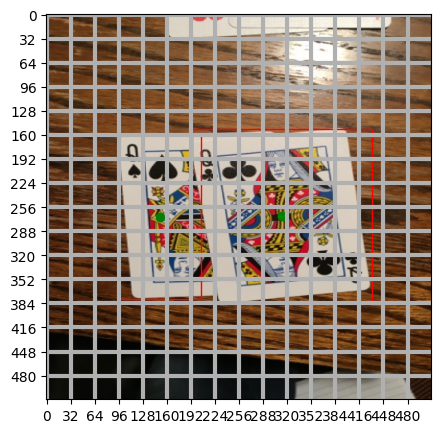

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [60]:
from typing import List
def decode_prediction(pred, upsample=32, threshold=0.7) -> List[List[List[float]]]:
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    result = []
    ### YOUR CODE HERE ###
    # 3 for: one for batch
    # two for x and y coord of the grid (hyperpixels)
    # result[0] == bboxes on image 0
    # result[0][0] == first bbox on image 0
    # result[0][0] == [xmin, ymin, xmax, ymax, class]
    for batch_idx in range(b):
        bboxes = []
        for i in range(h):
            for j in range(w):
                confidence = pred[batch_idx, 4, i, j].item()
                if confidence < threshold:
                    continue

                dx = pred[batch_idx, 0, i, j].item()
                dy = pred[batch_idx, 1, i, j].item()
                w_pred = pred[batch_idx, 2, i, j].item()
                h_pred = pred[batch_idx, 3, i, j].item()

                x_center = (j + dx) * (img_w / w)
                y_center = (i + dy) * (img_h / h)

                box_width = w_pred * img_w
                box_height = h_pred * img_h

                xmin = x_center - box_width / 2
                ymin = y_center - box_height / 2
                xmax = x_center + box_width / 2
                ymax = y_center + box_height / 2

                if c == 6:
                    class_idx = int(pred[batch_idx, 5, i, j].item())
                else:
                    class_probs = pred[batch_idx, 5:, i, j]
                    class_idx = torch.argmax(class_probs).item()

                bbox = [
                    float(xmin),
                    float(ymin),
                    float(xmax),
                    float(ymax),
                    int(class_idx)
                ]
                bboxes.append(bbox)
        result.append(bboxes)
    return result

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [61]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [[100, 200, 200, 300, 2]]
    target2 = [[0, 250, 200, 300, 0], [0, 100, 100, 300, 1]]
    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": target1},
            {"image": torch.rand((3, 512, 512)), "bboxes": target2},
        ]
    )

    target = result["target"]
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat(
        [target, torch.zeros(2, 2, 16, 16)], dim=1
    )  # Добавляем два канала
    assert target.shape == (2, 8, 16, 16)  # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([0.5, 0.6, 0.9])  # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([0.9, 0.6, 0.5])  # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([0.6, 0.9, 0.5])  # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print("Actual:  ", actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [target1, [target2[1], target2[0]]]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print("Expected:", expected)

    # Сравниваем
    assert actual == expected


test_decode_predictions()

Actual:   [[[100.0, 200.0, 200.0, 300.0, 2]], [[0.0, 100.0, 100.0, 300.0, 1], [0.0, 250.0, 200.0, 300.0, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно, можно при помощи ```list(model.children())[:-2]```) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [62]:
C = 6 # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(model.children())[:-2])
        self.additional_layers = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 5 + 6, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = self.backbone(img)
        output = self.additional_layers(img)

        return output

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [63]:
import torch.nn.functional as F

In [64]:
def special_loss(pred, target, C=C):

    obj_mask = target[:, 4, :, :] > 0.5
    no_obj_mask = target[:, 4, :, :] <= 0.5

    N = obj_mask.sum().float()

    pred_xy = pred[:, 0:2, :, :]
    target_xy = target[:, 0:2, :, :]

    localization_loss = F.mse_loss(pred_xy[obj_mask], target_xy[obj_mask], reduction='sum')

    pred_wh = torch.sqrt(pred[:, 2:4, :, :].clamp(min=1e-6))
    target_wh = torch.sqrt(target[:, 2:4, :, :].clamp(min=1e-6))

    box_loss = F.mse_loss(pred_wh[obj_mask], target_wh[obj_mask], reduction='sum') # MSE по корням ширины и высоты

    pred_class = pred[:, 5:5+C, :, :].permute(0, 2, 3, 1).contiguous()
    target_class = target[:, 5, :, :].long()

    classification_loss = F.cross_entropy(pred_class[obj_mask], target_class[obj_mask], reduction='sum')

    pred_conf = pred[:, 4, :, :]
    target_conf = target[:, 4, :, :]

    obj_conf_loss = F.binary_cross_entropy_with_logits(
        pred_conf[obj_mask],
        target_conf[obj_mask],
        reduction='sum'
    )

    no_obj_conf_loss = F.binary_cross_entropy_with_logits(
        pred_conf[no_obj_mask],
        target_conf[no_obj_mask],
        reduction='sum'
    )

    confidence_loss = obj_conf_loss + 0.1*no_obj_conf_loss

    return localization_loss + box_loss + classification_loss + confidence_loss

In [65]:
def special_loss(pred, target, C=C):

    obj_mask = target[:, 4, :, :] > 0.5
    obj_mask = obj_mask.unsqueeze(1)


    no_obj_mask = target[:, 4, :, :] <= 0.5
    no_obj_mask = no_obj_mask.unsqueeze(1)

    pred_xy = pred[:, 0:2, :, :]
    target_xy = target[:, 0:2, :, :]

    localization_loss = F.mse_loss(pred_xy * obj_mask,
                                 target_xy * obj_mask,
                                 reduction='sum')

    pred_wh = torch.sqrt(pred[:, 2:4, :, :].clamp(min=1e-6))
    target_wh = torch.sqrt(target[:, 2:4, :, :].clamp(min=1e-6))
    box_loss = F.mse_loss(pred_wh * obj_mask,
                         target_wh * obj_mask,
                         reduction='sum')


    pred_class = pred[:, 5:5+C, :, :]
    target_class = target[:, 5, :, :].long()


    classification_loss = F.cross_entropy(
        pred_class.permute(0, 2, 3, 1)[obj_mask.squeeze(1)],
        target_class[obj_mask.squeeze(1)],
        reduction='sum'
    )

    pred_conf = torch.sigmoid(pred[:, 4, :, :])
    target_conf = target[:, 4, :, :]

    obj_conf_loss = F.binary_cross_entropy(
        pred_conf[obj_mask.squeeze(1)],
        target_conf[obj_mask.squeeze(1)],
        reduction='sum'
    )

    no_obj_conf_loss = F.binary_cross_entropy(
        pred_conf[no_obj_mask.squeeze(1)],
        target_conf[no_obj_mask.squeeze(1)],
        reduction='sum'
    )*0.1

    confidence_loss = obj_conf_loss + no_obj_conf_loss

    total_loss = (localization_loss + box_loss + classification_loss +  confidence_loss)

    return total_loss

# Задача 4. 1 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [66]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images = batch['image'].to(device)
        targets = batch['target'].to(device)
        opt.zero_grad()
        output = model(images)
        loss = special_loss(output, targets)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 275.176;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 250.719;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 237.112;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 228.176;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 222.387;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 217.527;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 213.635;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 210.858;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 208.888;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 207.433;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 206.479;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 205.676;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 205.121;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 204.541;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 204.019;


Запустим обученный детектор на тестовых изображениях:

In [68]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [69]:
# Нужно сделать предсказание и переложить результат на cpu
images = batch['image'].to(device)
model.eval()  # Переводим модель в режим оценки
with torch.no_grad():
    output = model(images)
    output = output.cpu()

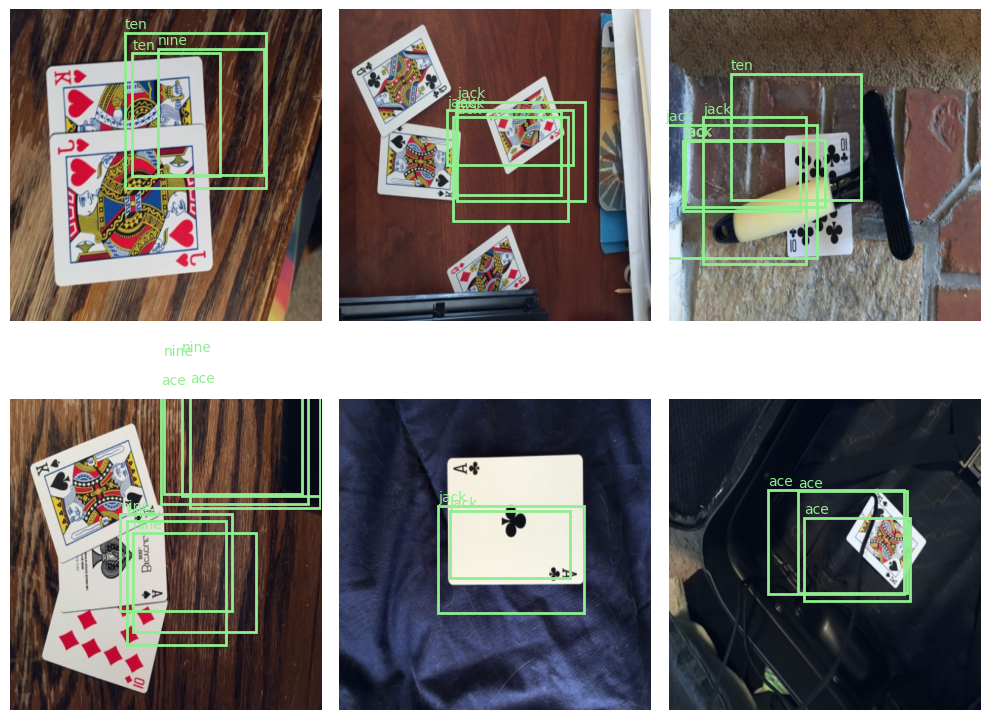

In [70]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
out = [output[i] for i in range(6)]
visualize(out, decode_prediction(output, threshold=0.1))

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 4 but better (1 балл)

## Прикручиваем NMS :^)

Напомним принцип работы алгоритма:
- Сортируем bbox в порядке убывания уверенности
- Считаем Intersection over Union (IoU) для всех bbox
- Выкидываем все, пересечение с которыми больше порога
- Идем дальше по списку, пока не дойдем до конца

In [71]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return intersection / (area1 + area2 - intersection + 1e-3) # Чтобы не было zero division

In [72]:
def NMS(bboxes, threshold=0.5):
    if not bboxes:
        return []

    boxes_with_conf = [(box, box[4]) for box in bboxes]

    boxes_with_conf.sort(key=lambda x: x[1], reverse=True)

    selected = []
    while boxes_with_conf:
        current = boxes_with_conf.pop(0)
        selected.append(current[0])

        boxes_with_conf = [
            (box, conf) for (box, conf) in boxes_with_conf
            if calculate_iou(current[0], box) <= threshold
        ]
    return selected

In [73]:
def decode_prediction_nms(pred, upsample=32, confidence_threshold=0.1, nms_threshold=0.5):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    result = []

    for batch_idx in range(b):
        bboxes = []

        for i in range(h):
            for j in range(w):
                confidence = pred[batch_idx, 4, i, j].item()

                if confidence < confidence_threshold:
                    continue

                dx = pred[batch_idx, 0, i, j].item()
                dy = pred[batch_idx, 1, i, j].item()
                w_pred = pred[batch_idx, 2, i, j].item()
                h_pred = pred[batch_idx, 3, i, j].item()

                x_center = (j + dx) * (img_w / w)
                y_center = (i + dy) * (img_h / h)

                box_width = w_pred * img_w
                box_height = h_pred * img_h

                xmin = max(0, x_center - box_width / 2)
                ymin = max(0, y_center - box_height / 2)
                xmax = min(img_w, x_center + box_width / 2)
                ymax = min(img_h, y_center + box_height / 2)

                if c == 6:
                    class_idx = int(pred[batch_idx, 5, i, j].item())
                else:
                    class_probs = pred[batch_idx, 5:, i, j]
                    class_idx = torch.argmax(class_probs).item()

                bboxes.append([float(xmin), float(ymin), float(xmax), float(ymax), int(class_idx)])

        bboxes = NMS(bboxes, nms_threshold)
        result.append(bboxes)
    return result

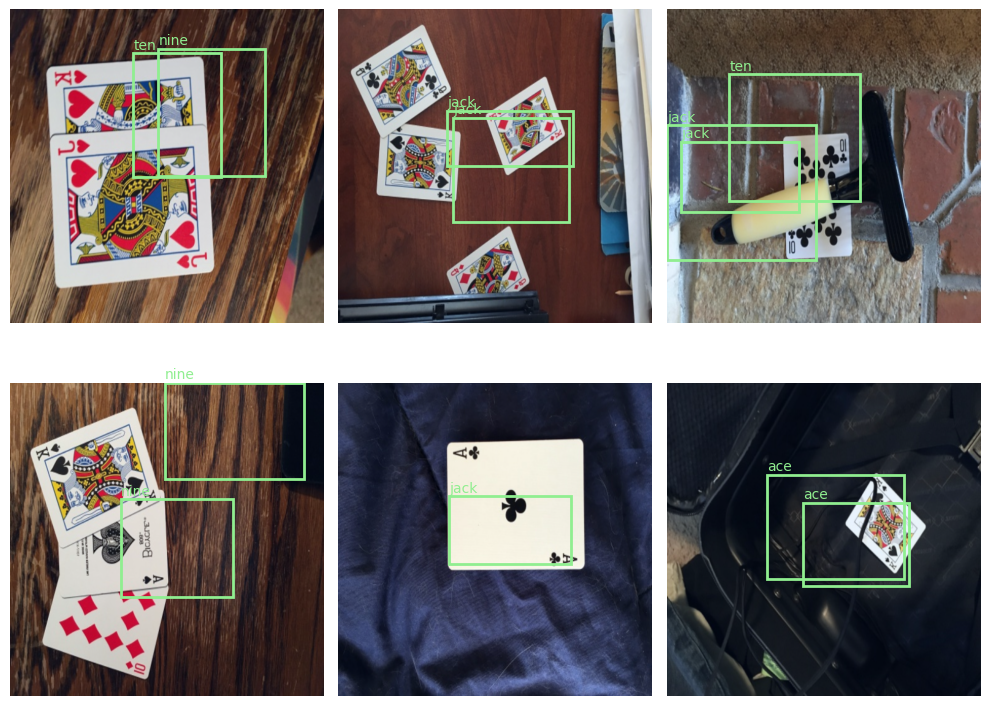

In [74]:
out = [output[i] for i in range(6)]
visualize(out, decode_prediction_nms(output))

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [75]:
import os

if os.path.exists('train'):
    shutil.rmtree('train')
if os.path.exists('valid'):
    shutil.rmtree('valid')

os.makedirs('train/images', exist_ok=True)
os.makedirs('train/labels', exist_ok=True)
os.makedirs('valid/images', exist_ok=True)
os.makedirs('valid/labels', exist_ok=True)

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [76]:
def annotation2txt(bboxes, w_im, h_im):
    lines = []

    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_id = bbox

        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2

        cx_norm = cx / w_im
        cy_norm = cy / h_im
        w_norm = (xmax - xmin) / w_im
        h_norm = (ymax - ymin) / h_im

        line = f"{class_id} {cx_norm} {cy_norm} {w_norm} {h_norm}"
        lines.append(line)
    return lines

In [77]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [78]:
list(train_ds.class_dict.keys())

['king', 'jack', 'ace', 'ten', 'nine', 'queen']

In [79]:
# Собираем YAML

nc = 6 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"""train: ../train/images
val: ../valid/images

nc: {nc}
names: {names}""")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [80]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')

results = model.train(data='data.yaml', epochs=20, imgsz=512, device='0')

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False,

train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2425.67it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 508.7±50.6 MB/s, size: 116.7 KB)


val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1164.02it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.62G     0.6464      3.354      1.031         29        512: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         37         63     0.0152          1      0.253       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.62G     0.6382      2.781     0.9855         24        512: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         37         63    0.00771          1      0.361      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.62G     0.6965      2.228      1.026         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]

                   all         37         63      0.773      0.145      0.418      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.62G      0.662       1.85      1.016         10        512: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         37         63      0.531      0.799       0.58      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.62G     0.6732      1.648      1.018         28        512: 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         37         63      0.456      0.791      0.503      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.65G     0.6439      1.545     0.9971         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         37         63      0.503      0.811       0.68      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.66G     0.6034      1.411     0.9742         24        512: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         37         63      0.604      0.826       0.77      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.68G     0.5828      1.373     0.9576         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         37         63      0.595       0.83      0.762      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.68G     0.5927      1.314     0.9783         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         37         63      0.562      0.778      0.717      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.71G     0.5743      1.236     0.9569         20        512: 100%|██████████| 21/21 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         37         63      0.614       0.87      0.823      0.758


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.72G     0.4655      1.434     0.8804         10        512: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         37         63      0.736      0.839      0.852      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.73G     0.4278      1.209     0.8608          6        512: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         37         63      0.837      0.825        0.9      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.74G     0.4322      1.188     0.8658          8        512: 100%|██████████| 21/21 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         37         63      0.704      0.868      0.854      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.76G     0.4019      1.056     0.8512         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         37         63      0.801      0.879      0.885      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.78G     0.3927      0.974     0.8426         14        512: 100%|██████████| 21/21 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         37         63      0.831      0.969      0.907      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.79G     0.3875     0.9409     0.8437         10        512: 100%|██████████| 21/21 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         37         63       0.87      0.937      0.955       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       5.8G     0.3807     0.9028     0.8338         13        512: 100%|██████████| 21/21 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         37         63      0.931      0.948      0.971      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.82G     0.3686      0.869     0.8343         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         37         63      0.944      0.952      0.972      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.84G     0.3473     0.8386     0.8331          8        512: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         37         63      0.937      0.938      0.977      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.85G     0.3428     0.8385     0.8325          9        512: 100%|██████████| 21/21 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         37         63       0.88      0.981      0.965      0.934



20 epochs completed in 0.030 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.4MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


                   all         37         63      0.937      0.937      0.977      0.934
                  king          8          9       0.89          1      0.995      0.966
                  jack         11         15          1      0.962      0.995      0.989
                   ace         10         14      0.993          1      0.995      0.933
                   ten         10         10       0.75          1      0.954      0.873
                  nine          8          9          1      0.662      0.925      0.887
                 queen          5          6      0.992          1      0.995      0.959
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train3


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [81]:
model.eval()
images = (images - torch.min(images))/(torch.max(images) - torch.min(images)) # модель настоятельно попросила все нормализовать
with torch.no_grad():
    model.predict(images, save=True)


0: 512x512 1 nine, 2.2ms
1: 512x512 1 jack, 2.2ms
2: 512x512 1 jack, 2.2ms
3: 512x512 1 ten, 2.2ms
4: 512x512 1 jack, 2.2ms
5: 512x512 1 ace, 2.2ms
Speed: 0.0ms preprocess, 2.2ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/train32


In [82]:
results = glob.glob('runs/detect/train2/*')

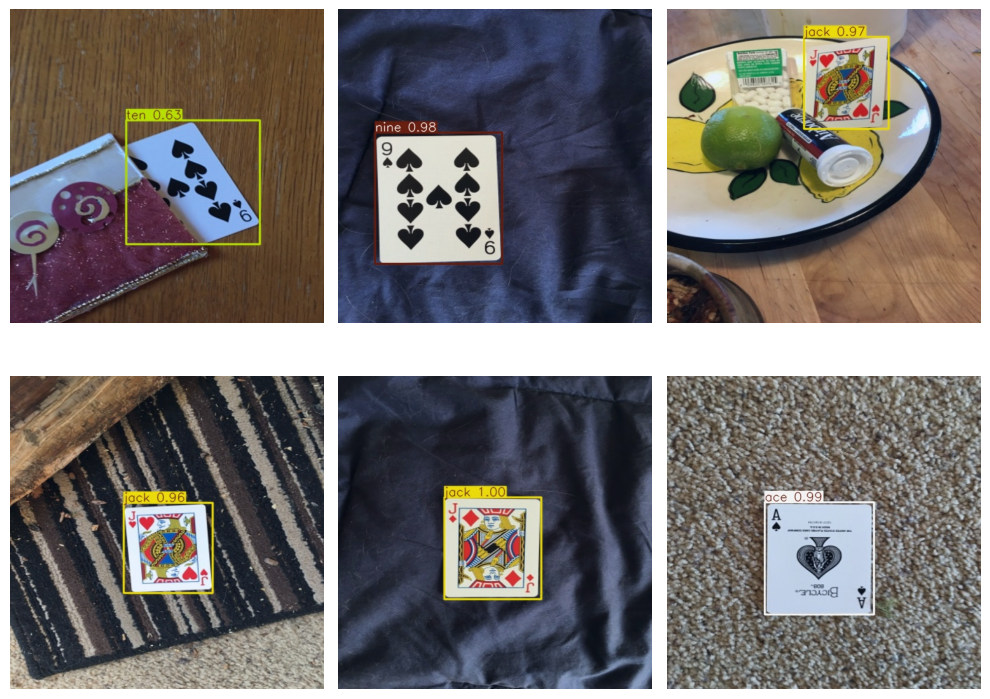

In [83]:
fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )
for i, ax in enumerate(axes.reshape(-1)):
    ax.axis(False)
    if i >= len(images):
        break
    img = plt.imread(results[i])[:, :, ::-1]
    ax.imshow(img)
fig.tight_layout()
plt.show()

## Бонус (1 балл)

Реализуйте подсчет mAP для самописной модели. Если найдете готовый код на гитхабах -- используйте с указанием ссылок :)

Сравните свою модель с YOLO11. Что получается?